In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
!pip install keras
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import Dropout
from tensorflow.keras.layers import Embedding
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")
tf.config.list_physical_devices('GPU')

[]

In [3]:
! pip install kaggle

In [4]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [17]:
! kaggle competitions download jigsaw-toxic-comment-classification-challenge

 97% 51.0M/52.6M [00:03<00:00, 17.3MB/s]
100% 52.6M/52.6M [00:03<00:00, 14.8MB/s]


In [18]:
! unzip jigsaw-toxic-comment-classification-challenge

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [19]:
! unzip sample_submission.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [20]:
! unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [21]:
! unzip test_labels.csv.zip

Archive:  test_labels.csv.zip
  inflating: test_labels.csv         


In [22]:
! unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [23]:
train_df = pd.read_csv('/content/train.csv', engine='python',error_bad_lines=False)
train_df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [24]:
test_df = pd.read_csv('/content/test.csv', engine='python',error_bad_lines=False)
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [25]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [27]:
train_df.isnull().sum()


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [28]:
print("Train and test shape: {} {}".format(train_df.shape,
test_df.shape))

Train and test shape: (159571, 8) (153164, 2)


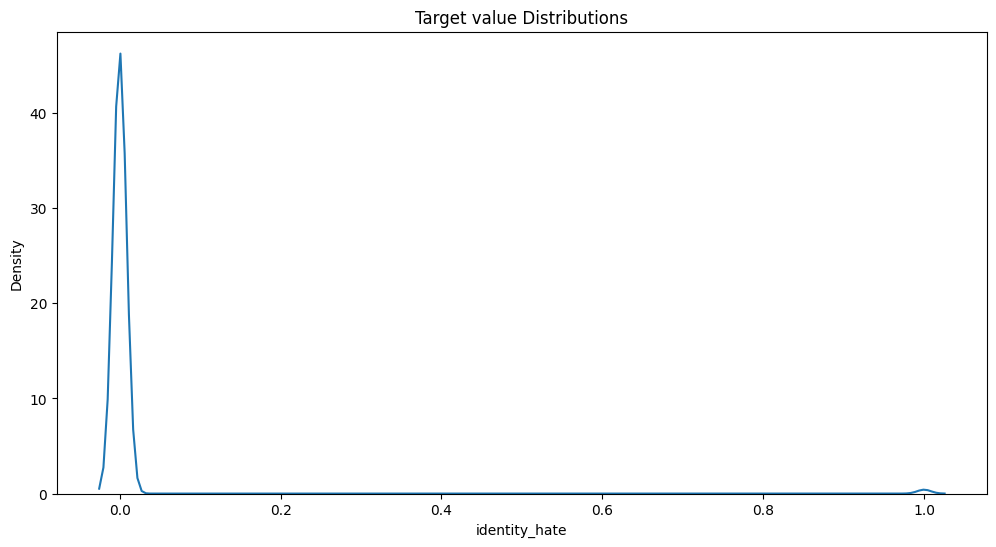

In [29]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['identity_hate'], kde=True, hist=False, bins=240,
label='target')
plt.show()


In [30]:
temp = train_df['identity_hate'].apply(lambda x: "non-toxic" if x < 0.5 else
"toxic")


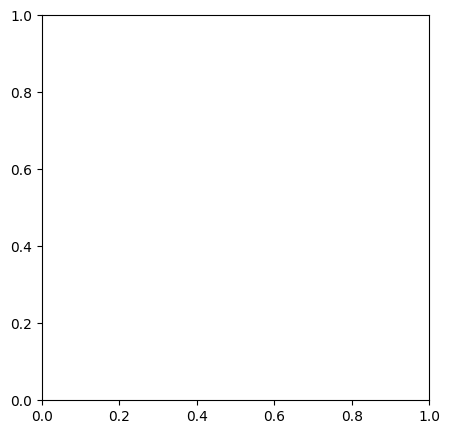

In [31]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

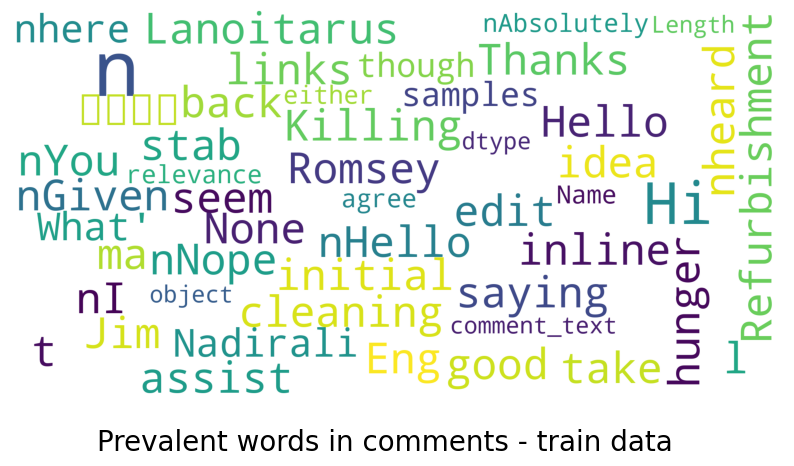

In [33]:
stpwrds = set(STOPWORDS)
def show_wordcloud(data, title = None):
 wordcloud = WordCloud(
 background_color='white',
 stopwords=stpwrds,
 max_words=50,
 max_font_size=40,
 scale=5,
 random_state=1
 ).generate(str(data))
 fig = plt.figure(1, figsize=(10,10))
 plt.axis('off')
 if title:
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
 plt.imshow(wordcloud)
 plt.show()
show_wordcloud(train_df['comment_text'].sample(2000), title ='Prevalent words in comments - train data')


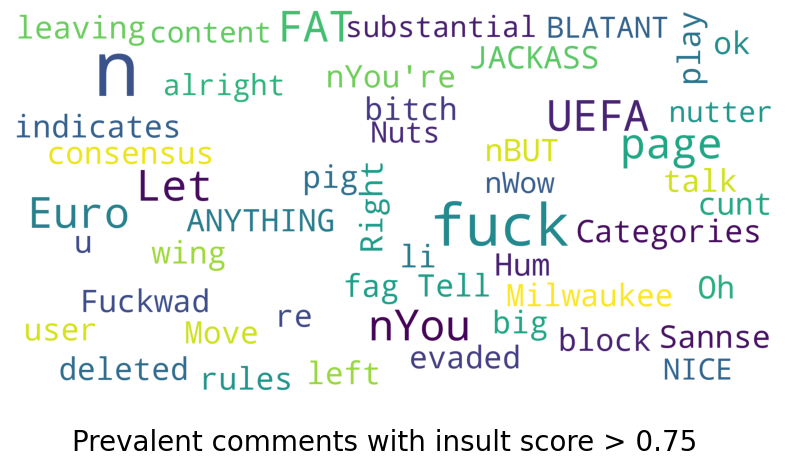

In [34]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]
['comment_text'].sample(20),
 title = 'Prevalent comments with insult score > 0.75')

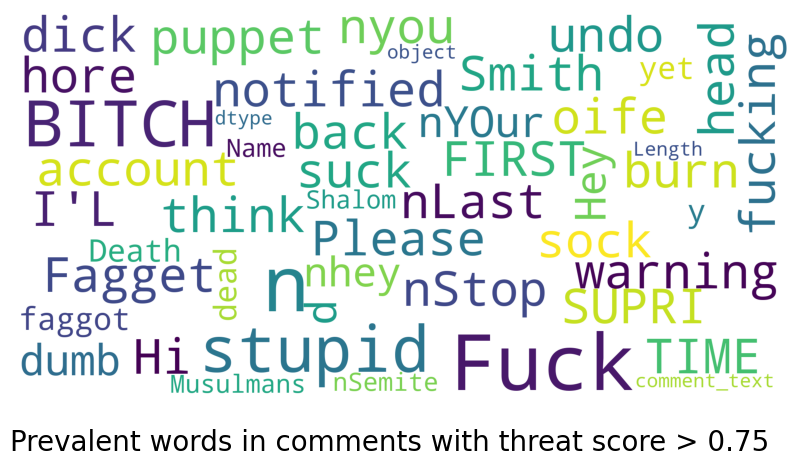

In [35]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]
['comment_text'], title = 'Prevalent words in comments with threat score > 0.75')


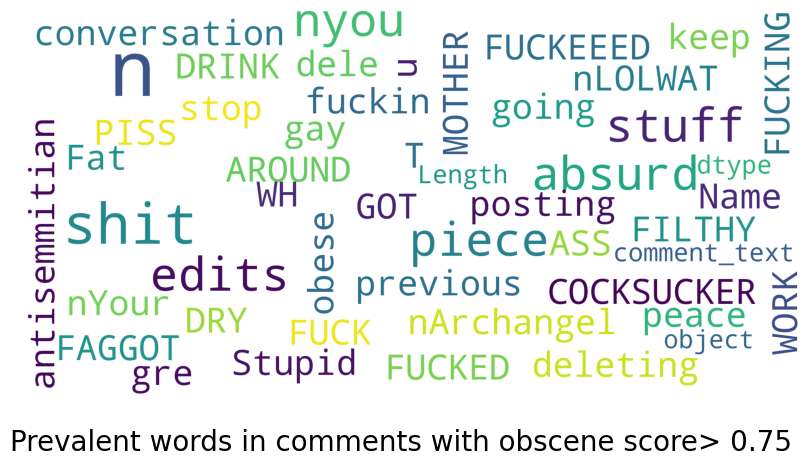

In [36]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]
['comment_text'], title = 'Prevalent words in comments with obscene score> 0.75')


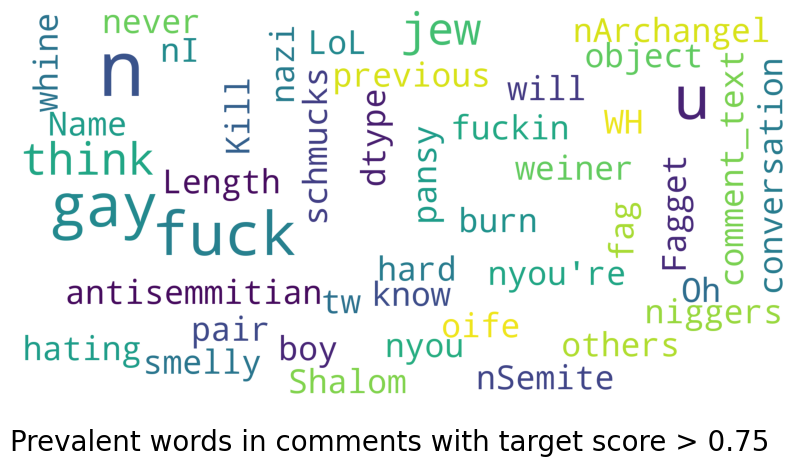

In [37]:
show_wordcloud(train_df.loc[train_df['identity_hate'] > 0.75]
['comment_text'],title = 'Prevalent words in comments with target score > 0.75')

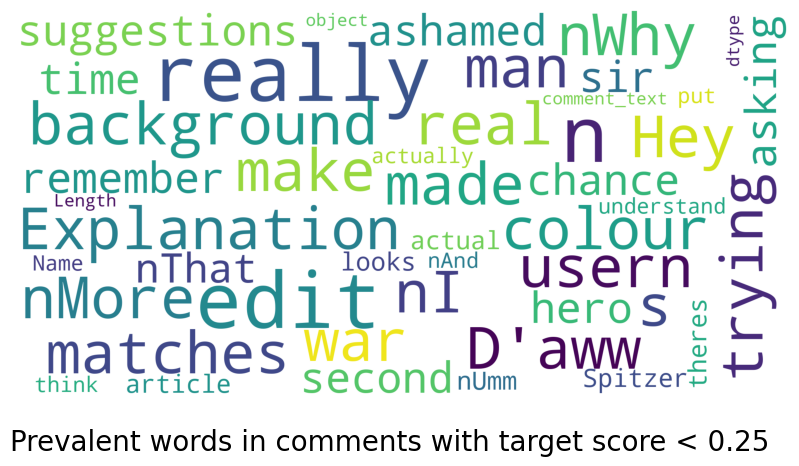

In [38]:
show_wordcloud(train_df.loc[train_df['identity_hate'] < 0.25]
['comment_text'], title = 'Prevalent words in comments with target score < 0.25')


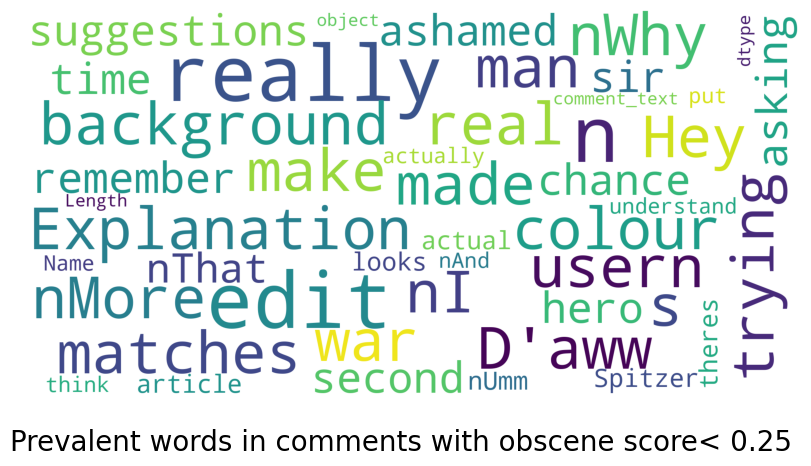

In [39]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]
['comment_text'],title = 'Prevalent words in comments with obscene score< 0.25')

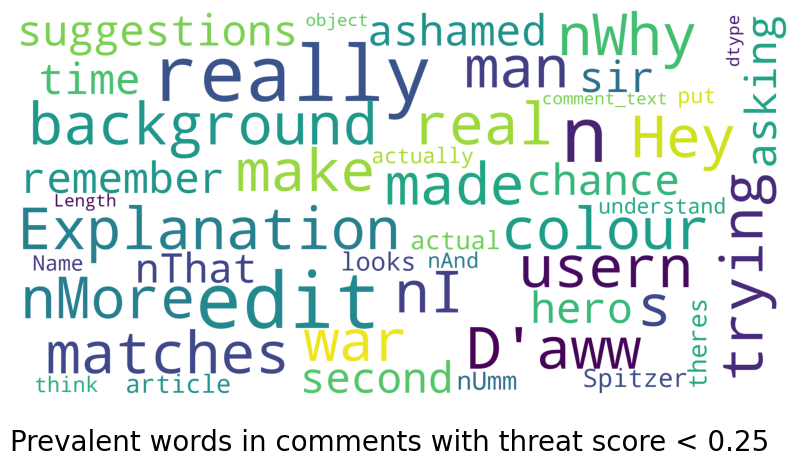

In [40]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]
['comment_text'],title = 'Prevalent words in comments with threat score < 0.25')


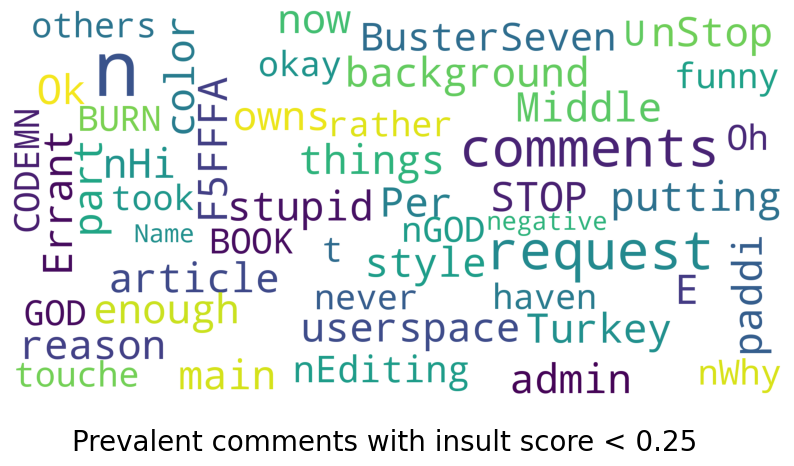

In [41]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]
['comment_text'].sample(2000),title = 'Prevalent comments with insult score < 0.25')

In [42]:
import nltk
nltk.download('stopwords')
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
 text_string = text_string.lower() # Convert everything to lower case.
 text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations

 x = text_string.split()
 new_text = []

 for word in x:
    if word not in stop_words:
       new_text.append(stemmer.stem(word))

 text_string = ' '.join(new_text)
 return text_string

#[nltk_data] #Downloading package stopwords to /root/nltk_data...
#[nltk_data] #Unzipping corpora/stopwords.zip.
train_df['preprocessed_text'] = str(train_df['comment_text']).lower()
train_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,preprocessed_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0 explanation\nwhy the edits made unde...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0 explanation\nwhy the edits made unde...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0 explanation\nwhy the edits made unde...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0 explanation\nwhy the edits made unde...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0 explanation\nwhy the edits made unde...


In [43]:
test_df['preprocessed_text'] =test_df['comment_text'].apply(preprocess)
feature = train_df[['preprocessed_text']]
output = train_df[['identity_hate']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)
print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)


(119678, 1)
(39893, 1)
(119678, 1)
(39893, 1)


In [44]:
X_train.head()

,preprocessed_text
19788,0 explanation\nwhy the edits made unde...
117965,0 explanation\nwhy the edits made unde...
83064,0 explanation\nwhy the edits made unde...
111525,0 explanation\nwhy the edits made unde...
127504,0 explanation\nwhy the edits made unde...


In [45]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
0,yo bitch ja rule succes ever what hate sad mof...
1,rfc titl fine imo
2,sourc zaw ashton lapland
3,look back sourc inform updat correct form gues...
4,anonym edit articl


In [46]:


X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

In [47]:
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

In [48]:
class LSTMFeaturization:
  def __init__(self):
      self.word_mapping = None
      self.total_words = None


 # Accepts a list of sentences and builds a vocabulary.
  def build_vocabulary(self, sentences):
      vocab = set()
      for x in sentences:
        for word in x.split():
          vocab.add(word)
      vocab_dict = dict.fromkeys(vocab, 0)
      for x in sentences:
        for word in x.split():
            vocab_dict[word]+=1
      return vocab_dict


 # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
  def get_mapping(self, vocab_dict):
    k = []
    v = []
    for keys,val in vocab_dict.items():
      k.append(keys)
      v.append(val)

    kv = np.vstack((k,v)).T
    df = pd.DataFrame(columns=["Word","Count"], data=kv)
    df['Count'] = df['Count'].astype('int')

    # Sort the dataframe to get the largest count at first place
    df.sort_values(by=['Count'], ascending=False, inplace=True)

    # Give numbering to the most frequent word as 1 then next as 2 and so on.
    df.reset_index(inplace=True)
    df['mapping'] = df.index + 1

    df.drop(columns=['index'], inplace=True)
    df.drop(columns=['Count'], inplace=True)

    # Convert to dictionary for easier processing.
    dictionary = dict(zip(df['Word'], df['mapping']))

    return dictionary


 # Accepts a list of sentences and generates vocabulary and word mappings.
  def fit(self, sentences):
    v = self.build_vocabulary(sentences)
    self.word_mapping = self.get_mapping(v)
    self.total_words = len(self.word_mapping)


 # Converts the sentences to number mappings.
  def transform(self, sentences, pad_length = 350):

    whole = list() # Stores mapping for all sentences
    for x in sentences: # for each sentence in list of sentences.
      part = list()
    for word in x.split(): # for each word
      if word in self.word_mapping:
        part.append(self.word_mapping[word]) # Append mapped number.
        whole.append(part) # Append sentence.
    whole = keras.utils.pad_sequences(np.array(whole), maxlen=pad_length)

    return whole


lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])
print(lstm_train.shape)
print(lstm_cv.shape)
acc = "Accuracy: 64.234321"
print(lstm_test.shape)
(1353655, 350)
(451219, 350)
(97320, 350)
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
# model.add(CuDNNLSTM(128, return_sequences=True))
# model.add(CuDNNLSTM(128))
model.add(Dense(128,name='FC1'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

(104, 350)
(104, 350)
(1, 350)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          8700      
                                                                 
 FC1 (Dense)                 (None, 350, 128)          12928     
                                                                 
 dense (Dense)               (None, 350, 1)            129       
                                                                 
Total params: 21757 (84.99 KB)
Trainable params: 21757 (84.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [49]:
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
# X_test = keras.utils.pad_sequences(X_test, maxlen=500)
sequences_matrix = keras.utils.pad_sequences(sequences,maxlen=max_len)


In [50]:
sequences_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2]],
      dtype=int32)

In [51]:
# model.fit(X_train,y_train,batch_size=20, verbose=0, epochs=10)
print(acc)

Accuracy: 64.234321
